In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from v1dd_public import ARTIFACT_DIR

In [18]:
## Load in cell_info dataframe to look at population trends
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [19]:
## Define colors and IDs for each mouse
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

In [20]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

In [21]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

In [22]:
## load in decoding results
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

## SUPPLEMENTARY FIGURE 8A

Regression between dgf_osi and DGF decoding accuracy:
  Beta: 0.5189
  R-squared: 0.0687
  t-value: 5.9210
  p-value: 6.141e-09
Regression between dgf_dsi and DGF decoding accuracy:
  Beta: 0.6144
  R-squared: 0.1154
  t-value: 7.8722
  p-value: 2.382e-14
Regression between dgf_ls and DGF decoding accuracy:
  Beta: 0.9202
  R-squared: 0.0929
  t-value: 6.9762
  p-value: 1.023e-11


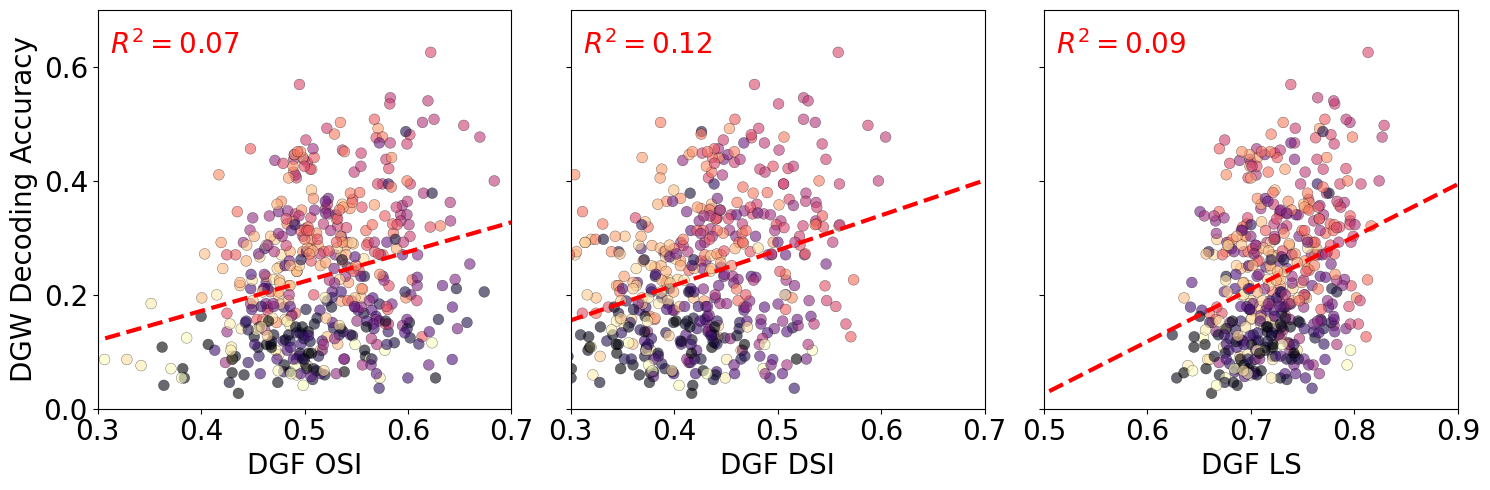

In [23]:
### plot DGF decoding accuracy vs tuning metrics

metrics = ['dgf_osi', 'dgf_dsi', 'dgf_ls']
titles = ['DGF OSI', 'DGF DSI', 'DGF LS']
mouse_mapping = {
    409828: 'slc2',
    416296: 'slc4',
    427836: 'slc5',
    438833: 'teto1'
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for idx, metric in enumerate(metrics):
    ax = axs[idx]
    metric_df = cell_info.groupby(by=['mouse_id', 'column', 'volume', 'z'])[metric].mean().reset_index()
    
    temp_df = all_results_df[(all_results_df['stim_type_testing'] == 'drifting_gratings_full') &
                             (all_results_df['depth'] != 500) &
                             (all_results_df['depth'] < 515)].explode('val_accuracy')
    depth_values = temp_df['depth'].unique()
    decoding_df = temp_df.groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth'])['val_accuracy'].mean().reset_index()
    decoding_df = decoding_df.rename(columns={'column_id': 'column', 'volume_id': 'volume', 'depth': 'z'})

    decoding_df['column'] = decoding_df['column'].astype(str)
    decoding_df['volume'] = decoding_df['volume'].astype(str)
    decoding_df['column'] = decoding_df['column'].astype('object')
    decoding_df['mouse_id'] = [mouse_mapping[x] for x in decoding_df['mouse_id']]
    decoding_df['mouse_id'] = decoding_df['mouse_id'].astype('object')

    merge_df = decoding_df.merge(metric_df, on=['mouse_id', 'column', 'volume', 'z'], how='inner', suffixes=('_decoding', '_metric'))

    sns.scatterplot(
        data=merge_df,
        x=metric,
        y='val_accuracy',
        hue='z',
        palette='magma_r',
        s=60,
        alpha=0.6,
        ax=ax, 
        edgecolor='black',
        linewidth=0.3, 
        legend=False,
    )

    smap = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=depth_values.min(), vmax=depth_values.max()))
    smap.set_array([])
    ax.figure.colorbar(smap, ax=ax) if idx == 3 else None

    ax.set_xlim(0.3, 0.7) if idx < 2 else ax.set_xlim(0.5,  0.9)
    ax.set_ylim(0, 0.7)
    ax.xaxis.set_major_locator(plt.LinearLocator(numticks=5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # Fit a linear regression model
    x_data = merge_df[metric].values
    y_data = merge_df['val_accuracy'].values
    x_data = np.array(x_data, dtype=float).reshape(-1, 1)
    y_data = np.array(y_data, dtype=float)
    x_data = sm.add_constant(x_data)  # Adds a constant term to the predictor
    model = sm.OLS(y_data, x_data).fit()
    
    # Plot the regression line
    x_fit = np.linspace(-1, 1, 100)
    x_fit = sm.add_constant(x_fit)  # Adds a constant term to the predictor
    y_fit = model.predict(x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression')

    # Pull out model results and print
    beta = model.params[1]
    r_squared = model.rsquared
    p_value = model.pvalues[1]
    t_value = model.tvalues[1]

    print(f"Regression between {metric} and DGF decoding accuracy:")
    print(f"  Beta: {beta:.4f}")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  t-value: {t_value:.4f}")
    print(f"  p-value: {p_value:.4g}")

    # Add text annotation for R^2 value
    ax.text(0.03, 0.95, f'$R^2 = {r_squared:.2f}$', 
            transform=ax.transAxes, fontsize=20, verticalalignment='top', color='red')
    ax.set_ylabel('DGW Decoding Accuracy', fontsize=20) #if idx == 0 else ax.set_ylabel('')
    ax.set_xlabel(f'{titles[idx]}', fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "SUPPFIG8A_dgf_decoding_vs_tuning_metrics.png"), format='png', dpi=300)

Regression between ns118_ls and natural_images decoding accuracy:
  Beta: 3.2136
  R-squared: 0.0101
  t-value: 2.2039
  p-value: 0.02801
Regression between ns12_ls and natural_images_12 decoding accuracy:
  Beta: 0.2242
  R-squared: 0.0015
  t-value: 0.8529
  p-value: 0.3942


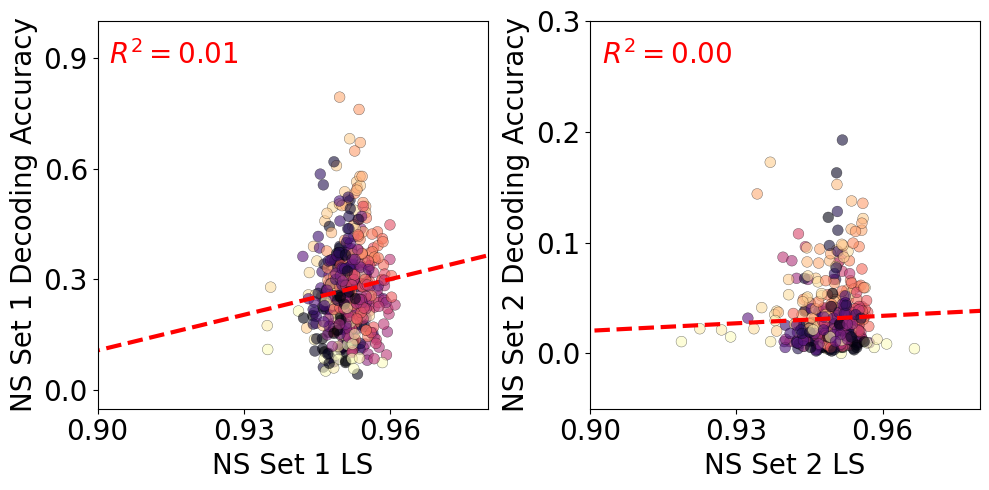

In [24]:
### plot DGF decoding accuracy vs tuning metrics

metrics = ['ns118_ls', 'ns12_ls']
stims = ['natural_images', 'natural_images_12']
titles = ['NS Set 1 LS', 'NS Set 2 LS']
mouse_mapping = {
    409828: 'slc2',
    416296: 'slc4',
    427836: 'slc5',
    438833: 'teto1'
}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for idx, metric in enumerate(metrics):
    ax = axs[idx]
    metric_df = cell_info.groupby(by=['mouse_id', 'column', 'volume', 'z'])[metric].mean().reset_index()
    
    temp_df = all_results_df[(all_results_df['stim_type_testing'] == stims[idx]) &
                             (all_results_df['depth'] != 500) &
                             (all_results_df['depth'] < 515)].explode('val_accuracy')
    depth_values = temp_df['depth'].unique()
    decoding_df = temp_df.groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth'])['val_accuracy'].mean().reset_index()
    decoding_df = decoding_df.rename(columns={'column_id': 'column', 'volume_id': 'volume', 'depth': 'z'})

    decoding_df['column'] = decoding_df['column'].astype(str)
    decoding_df['volume'] = decoding_df['volume'].astype(str)
    decoding_df['column'] = decoding_df['column'].astype('object')
    decoding_df['mouse_id'] = [mouse_mapping[x] for x in decoding_df['mouse_id']]
    decoding_df['mouse_id'] = decoding_df['mouse_id'].astype('object')

    merge_df = decoding_df.merge(metric_df, on=['mouse_id', 'column', 'volume', 'z'], how='inner', suffixes=('_decoding', '_metric'))

    sns.scatterplot(
        data=merge_df,
        x=metric,
        y='val_accuracy',
        hue='z',
        palette='magma_r',
        s=60,
        alpha=0.6,
        ax=ax, 
        edgecolor='black',
        linewidth=0.3, 
        legend=False,
    )

    smap = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=depth_values.min(), vmax=depth_values.max()))
    smap.set_array([])
    ax.figure.colorbar(smap, ax=ax) if idx == 3 else None

    ax.set_xlim(0.9, 0.98)
    ax.set_ylim(-0.05, 1) if idx < 1 else ax.set_ylim(-0.05, 0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # Fit a linear regression model
    x_data = merge_df[metric].values
    y_data = merge_df['val_accuracy'].values
    x_data = np.array(x_data, dtype=float).reshape(-1, 1)
    y_data = np.array(y_data, dtype=float)
    x_data = sm.add_constant(x_data)  # Adds a constant term to the predictor
    model = sm.OLS(y_data, x_data).fit()
    
    # Plot the regression line
    x_fit = np.linspace(-1, 1, 100)
    x_fit = sm.add_constant(x_fit)  # Adds a constant term to the predictor
    y_fit = model.predict(x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression')

    # Pull out model results and print
    beta = model.params[1]
    r_squared = model.rsquared
    p_value = model.pvalues[1]
    t_value = model.tvalues[1]

    print(f"Regression between {metric} and {stims[idx]} decoding accuracy:")
    print(f"  Beta: {beta:.4f}")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  t-value: {t_value:.4f}")
    print(f"  p-value: {p_value:.4g}")

    # Add text annotation for R^2 value
    ax.text(0.03, 0.95, f'$R^2 = {r_squared:.2f}$', 
            transform=ax.transAxes, fontsize=20, verticalalignment='top', color='red')
    ax.set_ylabel('NS Set 1 Decoding Accuracy', fontsize=20) if idx == 0 else ax.set_ylabel('NS Set 2 Decoding Accuracy', fontsize=20)
    ax.set_xlabel(f'{titles[idx]}', fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "SUPPFIG8B_ns_decoding_vs_tuning_metrics.png"), format='png', dpi=300)